In [1]:
import pandas as pd
import lifelines as ll
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
TENURES = pd.read_csv('categorized/tenures-summarized-categorized.csv')

In [3]:
TENURES.head()

slug           coach franchise  seasons  games  wins  \
0       kruger|01|03|ATL       L. Kruger       ATL        3    191    69   
1       stotts|03|04|ATL       T. Stotts       ATL        2    137    52   
2      woodson|05|10|ATL      M. Woodson       ATL        6    492   206   
3         drew|11|13|ATL         L. Drew       ATL        3    230   128   
4  budenholzer|14|17|ATL  M. Budenholzer       ATL        4    328   189   

   losses  min_year  max_year  left_truncated ending  
0     122      2001      2003            True  fired  
1      85      2003      2004           False  fired  
2     286      2005      2010           False  fired  
3     102      2011      2013           False  fired  
4     139      2014      2017           False    NaN

In [4]:
TENURES.ending.value_counts()

fired               112
interim only         39
resigned             26
contract expired      2
traded                2
retired               2
mutual                2
died                  1
Name: ending, dtype: int64

In [5]:
tenures = TENURES[TENURES.ending != 'interim only']

In [6]:
death_event = ['fired', 'contract expired', 'mutual']

In [7]:
tenures['death'] = (tenures.ending.isin(death_event) * 1)

/home/ryan/.virtualenvs/coaching-survival/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [8]:
tenures.sample(5)

slug        coach franchise  seasons  games  wins  \
50      saunders|06|08|DET  F. Saunders       DET        3    246   176   
183     popovich|01|17|SAS  G. Popovich       SAS       17   1378   987   
204  iavaroni|08|09|VANMEM  M. Iavaroni    VANMEM        2    123    33   
120   hollins|15|16|NJNBRK   L. Hollins    NJNBRK        2    119    48   
47        irvine|01|01|DET    G. Irvine       DET        1     82    32   

     losses  min_year  max_year  left_truncated ending  death  
50       70      2006      2008           False  fired      1  
183     391      2001      2017            True    NaN      0  
204      90      2008      2009           False  fired      1  
120      71      2015      2016           False  fired      1  
47       50      2001      2001            True  fired      1

In [9]:
kmf = ll.KaplanMeierFitter()

In [10]:
kmf.fit(tenures.games, event_observed=tenures.death)

<lifelines.KaplanMeierFitter: fitted with 177 observations, 61 censored>

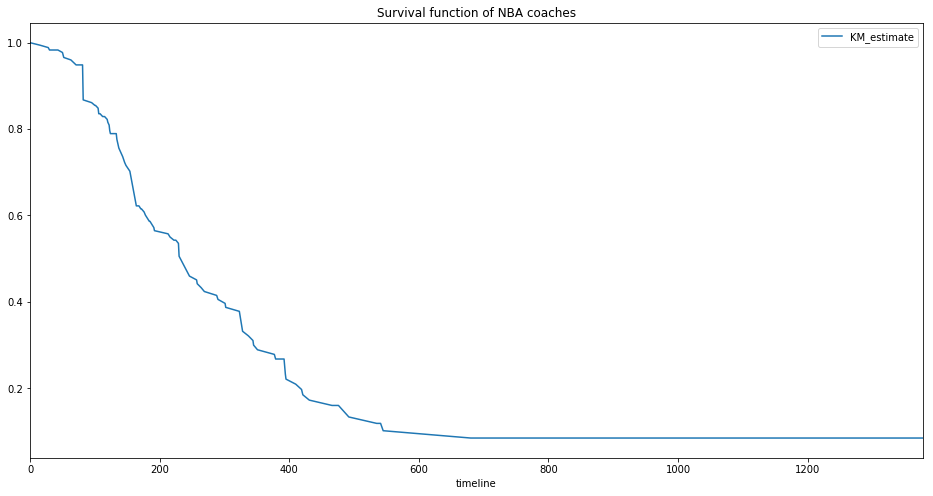

In [11]:
kmf.survival_function_.plot(figsize=(16,8))
plt.title('Survival function of NBA coaches');

Text(0.5,1,u'Survival function of NBA coaches')

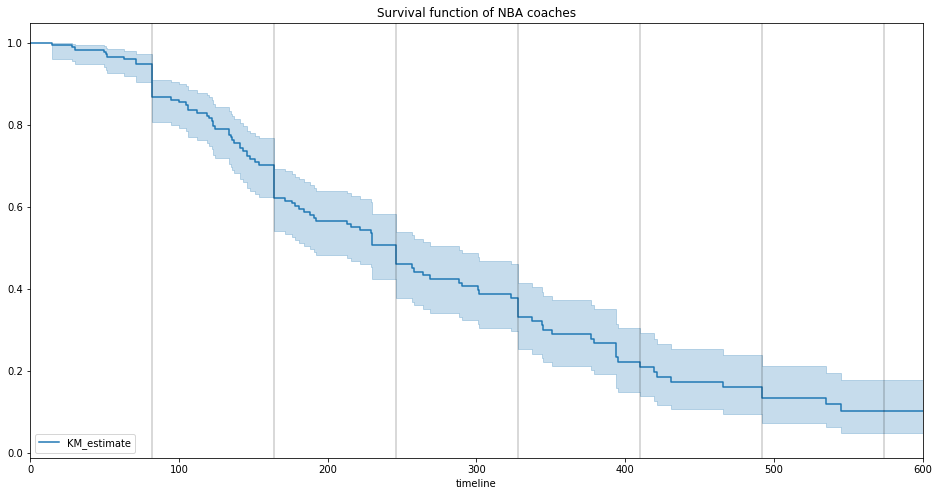

In [12]:
kmf.plot(figsize=(16,8))
[plt.axvline(g, c='black', alpha=0.2) for g in range(82, 82*20, 82)]
plt.xlim(0, 600)
plt.title('Survival function of NBA coaches')

In [13]:
POC = pd.read_csv('categorized/coach-list-poc.csv')

In [14]:
POC.head()

coach franchises  poc note
0   T. Porter    PHO|MIL  yes  NaN
1      T. Lue        CLE  yes  NaN
2   T. Corbin    SAC|UTA  yes  NaN
3    T. Brown     NJNBRK  yes  NaN
4  S. Vincent     CHARBH  yes  NaN

In [15]:
PLAYERS = pd.read_csv('categorized/coach-list-qualifications.csv')

In [16]:
PLAYERS.head()

coach      franchises former_nba_player   bbref_id
0       A. Gentry  PHO|NORLHP|LAC                no        NaN
1      A. Johnson      DAL|NJNBRK               yes  johnsav01
2        B. Berry             CHI                no        NaN
3  B. Bickerstaff      LAL|CHARBH                no        NaN
4        B. Brown             PHI                no        NaN

In [17]:
tenures_info = tenures.merge(
    POC[['coach','poc']], 
    how='left'
).merge(
    PLAYERS[['coach','former_nba_player']],
    how='left'
)

In [18]:
tenures_info.poc.isnull().sum()

0

In [19]:
tenures_info.former_nba_player.isnull().sum()

0

In [20]:
tenures_info.groupby(['poc','former_nba_player']).size().unstack('poc')

poc                no  yes
former_nba_player         
no                 49   14
yes                60   54

In [21]:
tenures_info.head()

slug           coach franchise  seasons  games  wins  \
0       kruger|01|03|ATL       L. Kruger       ATL        3    191    69   
1       stotts|03|04|ATL       T. Stotts       ATL        2    137    52   
2      woodson|05|10|ATL      M. Woodson       ATL        6    492   206   
3         drew|11|13|ATL         L. Drew       ATL        3    230   128   
4  budenholzer|14|17|ATL  M. Budenholzer       ATL        4    328   189   

   losses  min_year  max_year  left_truncated ending  death  poc  \
0     122      2001      2003            True  fired      1   no   
1      85      2003      2004           False  fired      1   no   
2     286      2005      2010           False  fired      1  yes   
3     102      2011      2013           False  fired      1  yes   
4     139      2014      2017           False    NaN      0   no   

  former_nba_player  
0                no  
1                no  
2               yes  
3               yes  
4                no

(0, 600)

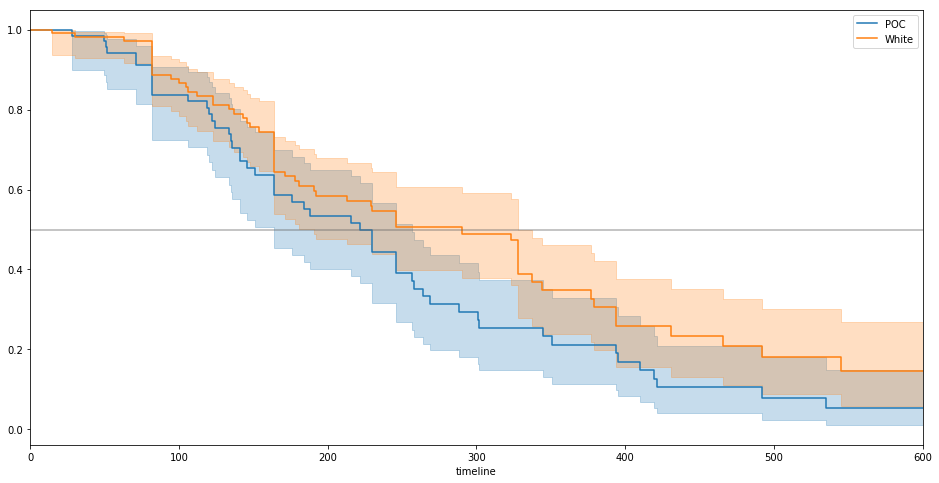

In [22]:
plt.figure(figsize=(16,8))
ax = plt.subplot(111)

ispoc = (tenures_info['poc'] == 'yes')

kmf.fit(tenures_info[ispoc].games, event_observed=tenures_info[ispoc].death, label="POC")
kmf.plot(ax=ax)
pocmed = kmf.median_
kmf.fit(tenures_info[~ispoc].games, event_observed=tenures_info[~ispoc].death, label="White")
kmf.plot(ax=ax)
whtmed = kmf.median_

plt.axhline(0.5, c='#666666', alpha=0.5)

plt.xlim(0,600)

In [23]:
print "The median survival time for POC coaches was {} games".format(pocmed)
print "The median survival time for white coaches was {} games".format(whtmed)

The median survival time for POC coaches was 222.0 games
The median survival time for white coaches was 290.0 games


(0, 600)

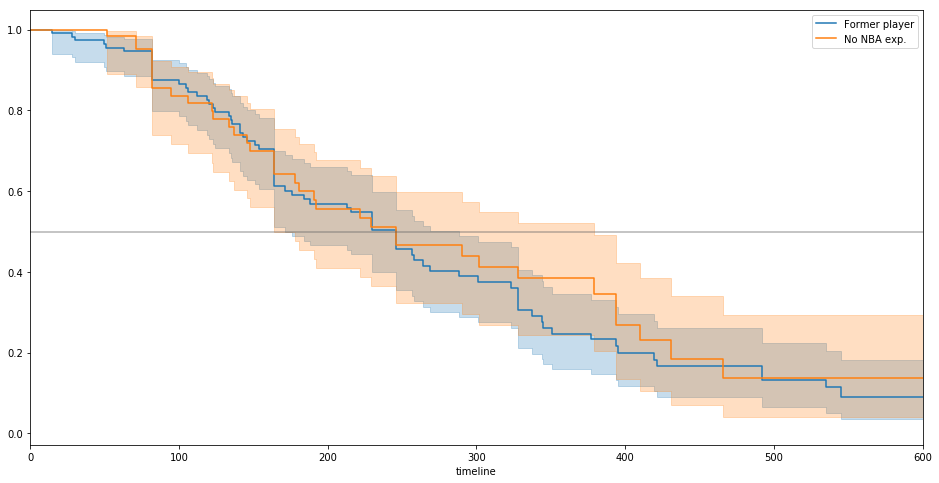

In [24]:
plt.figure(figsize=(16,8))
ax = plt.subplot(111)

former_player = (tenures_info['former_nba_player'] == 'yes')

kmf.fit(tenures_info[former_player].games, event_observed=tenures_info[former_player].death, label="Former player")
kmf.plot(ax=ax)
nbamed = kmf.median_
kmf.fit(tenures_info[~former_player].games, event_observed=tenures_info[~former_player].death, label="No NBA exp.")
kmf.plot(ax=ax)
nonmed = kmf.median_

plt.axhline(0.5, c='#666666', alpha=0.5)

plt.xlim(0,600)

In [25]:
print "The median survival time for former NBA players was {} games".format(nbamed)
print "The median survival time for non-players was {} games".format(nonmed)

The median survival time for former NBA players was 246.0 games
The median survival time for non-players was 246.0 games


In [26]:
rossi_dataset = ll.datasets.load_rossi()

In [27]:
rossi_dataset.head()

week  arrest  fin  age  race  wexp  mar  paro  prio
0    20       1    0   27     1     0    0     1     3
1    17       1    0   18     1     0    0     1     8
2    25       1    0   19     0     1    0     1    13
3    52       0    1   23     1     1    1     1     1
4    52       0    0   19     0     1    0     1     3

In [28]:
cph = ll.CoxPHFitter()
cph.fit(rossi_dataset, duration_col='week', event_col='arrest')

<lifelines.CoxPHFitter: fitted with 432 observations, 318 censored>

In [29]:
cph.print_summary()

n=432, number of events=114

        coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95    
fin  -0.3790     0.6846    0.1914 -1.9804 0.0477     -0.7541     -0.0038   *
age  -0.0572     0.9444    0.0220 -2.6037 0.0092     -0.1003     -0.0141  **
race  0.3141     1.3690    0.3080  1.0197 0.3079     -0.2897      0.9179    
wexp -0.1511     0.8598    0.2121 -0.7124 0.4762     -0.5670      0.2647    
mar  -0.4327     0.6488    0.3817 -1.1334 0.2570     -1.1810      0.3157    
paro -0.0850     0.9185    0.1957 -0.4341 0.6643     -0.4687      0.2988    
prio  0.0911     1.0954    0.0286  3.1819 0.0015      0.0350      0.1472  **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.640


In [30]:
regdata = tenures_info[['games','death','poc','former_nba_player']]
regdata['poc'] = (regdata.poc == "yes") * 1
regdata['former_nba_player'] = (regdata.former_nba_player == "yes") * 1

/home/ryan/.virtualenvs/coaching-survival/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ryan/.virtualenvs/coaching-survival/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
regdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177 entries, 0 to 176
Data columns (total 4 columns):
games                177 non-null int64
death                177 non-null int64
poc                  177 non-null int64
former_nba_player    177 non-null int64
dtypes: int64(4)
memory usage: 6.9 KB


In [32]:
cph = ll.CoxPHFitter(alpha=0.9)
cph.fit(
    regdata,
    duration_col='games',
    event_col='death'
)

<lifelines.CoxPHFitter: fitted with 177 observations, 61 censored>

In [33]:
cph.print_summary()

n=177, number of events=116

                    coef  exp(coef)  se(coef)      z      p  lower 0.90  upper 0.90   
poc               0.3421     1.4078    0.1914 1.7870 0.0739      0.0271      0.6570  .
former_nba_player 0.0282     1.0286    0.2046 0.1377 0.8905     -0.3085      0.3648   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.539


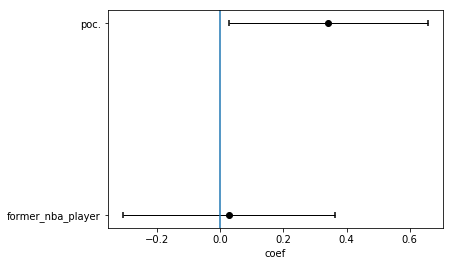

In [34]:
cph.plot()
plt.axvline(0)